<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[03:09:07] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


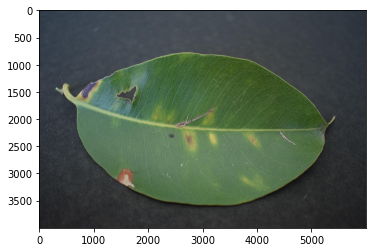

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

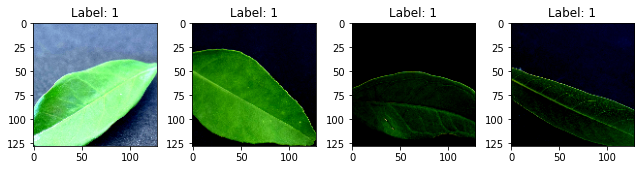

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[03:09:13] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[03:09:14] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.26288725716719 samples/sec                   batch loss = 1.0344133377075195 | accuracy = 0.4


Epoch[1] Batch[10] Speed: 1.2671799924545717 samples/sec                   batch loss = 0.84328293800354 | accuracy = 0.525


Epoch[1] Batch[15] Speed: 1.274542218695927 samples/sec                   batch loss = 1.766886591911316 | accuracy = 0.5666666666666667


Epoch[1] Batch[20] Speed: 1.275304010561695 samples/sec                   batch loss = 0.780299961566925 | accuracy = 0.5625


Epoch[1] Batch[25] Speed: 1.2749806973280238 samples/sec                   batch loss = 0.5241985321044922 | accuracy = 0.58


Epoch[1] Batch[30] Speed: 1.272927189532526 samples/sec                   batch loss = 0.7896836996078491 | accuracy = 0.5916666666666667


Epoch[1] Batch[35] Speed: 1.2713899492299312 samples/sec                   batch loss = 0.3751242458820343 | accuracy = 0.6285714285714286


Epoch[1] Batch[40] Speed: 1.2667561395580795 samples/sec                   batch loss = 0.6559523344039917 | accuracy = 0.61875


Epoch[1] Batch[45] Speed: 1.2729516247432144 samples/sec                   batch loss = 0.5129796862602234 | accuracy = 0.6111111111111112


Epoch[1] Batch[50] Speed: 1.2781589019722568 samples/sec                   batch loss = 0.6156141757965088 | accuracy = 0.605


Epoch[1] Batch[55] Speed: 1.2777582299609236 samples/sec                   batch loss = 0.6069559454917908 | accuracy = 0.6090909090909091


Epoch[1] Batch[60] Speed: 1.2719914381832402 samples/sec                   batch loss = 0.29810571670532227 | accuracy = 0.5958333333333333


Epoch[1] Batch[65] Speed: 1.2347387133845293 samples/sec                   batch loss = 0.6330791711807251 | accuracy = 0.5961538461538461


Epoch[1] Batch[70] Speed: 1.2702981213579818 samples/sec                   batch loss = 1.2183928489685059 | accuracy = 0.5964285714285714


Epoch[1] Batch[75] Speed: 1.2717820091971617 samples/sec                   batch loss = 1.0744895935058594 | accuracy = 0.5966666666666667


Epoch[1] Batch[80] Speed: 1.2664543531628227 samples/sec                   batch loss = 0.20757362246513367 | accuracy = 0.603125


Epoch[1] Batch[85] Speed: 1.2638695409930811 samples/sec                   batch loss = 0.7291614413261414 | accuracy = 0.5970588235294118


Epoch[1] Batch[90] Speed: 1.2733695830783451 samples/sec                   batch loss = 0.6535302400588989 | accuracy = 0.5944444444444444


Epoch[1] Batch[95] Speed: 1.2700454067370814 samples/sec                   batch loss = 0.43690556287765503 | accuracy = 0.6026315789473684


Epoch[1] Batch[100] Speed: 1.2639988500071497 samples/sec                   batch loss = 0.4554288983345032 | accuracy = 0.6125


Epoch[1] Batch[105] Speed: 1.262991264115498 samples/sec                   batch loss = 0.48729270696640015 | accuracy = 0.6142857142857143


Epoch[1] Batch[110] Speed: 1.2694771663140472 samples/sec                   batch loss = 0.20996451377868652 | accuracy = 0.625


Epoch[1] Batch[115] Speed: 1.2735100268741542 samples/sec                   batch loss = 0.606975257396698 | accuracy = 0.6260869565217392


Epoch[1] Batch[120] Speed: 1.2744660217922756 samples/sec                   batch loss = 1.1546361446380615 | accuracy = 0.625


Epoch[1] Batch[125] Speed: 1.2694484458631132 samples/sec                   batch loss = 0.3189741373062134 | accuracy = 0.626


Epoch[1] Batch[130] Speed: 1.2659302981428557 samples/sec                   batch loss = 1.0261483192443848 | accuracy = 0.6269230769230769


Epoch[1] Batch[135] Speed: 1.2754380940789403 samples/sec                   batch loss = 0.9416998624801636 | accuracy = 0.6296296296296297


Epoch[1] Batch[140] Speed: 1.26658734712366 samples/sec                   batch loss = 0.279809832572937 | accuracy = 0.6375


Epoch[1] Batch[145] Speed: 1.270758420247283 samples/sec                   batch loss = 0.5332321524620056 | accuracy = 0.6413793103448275


Epoch[1] Batch[150] Speed: 1.2687399714720566 samples/sec                   batch loss = 0.8469409942626953 | accuracy = 0.6416666666666667


Epoch[1] Batch[155] Speed: 1.2643497744667787 samples/sec                   batch loss = 0.31082695722579956 | accuracy = 0.6419354838709678


Epoch[1] Batch[160] Speed: 1.2705000383560818 samples/sec                   batch loss = 0.7912999391555786 | accuracy = 0.64375


Epoch[1] Batch[165] Speed: 1.2700851151226453 samples/sec                   batch loss = 0.5739458203315735 | accuracy = 0.646969696969697


Epoch[1] Batch[170] Speed: 1.2682786406393065 samples/sec                   batch loss = 0.7108889818191528 | accuracy = 0.6470588235294118


Epoch[1] Batch[175] Speed: 1.256689423660602 samples/sec                   batch loss = 1.0250146389007568 | accuracy = 0.6457142857142857


Epoch[1] Batch[180] Speed: 1.261601041873381 samples/sec                   batch loss = 0.2171827107667923 | accuracy = 0.6513888888888889


Epoch[1] Batch[185] Speed: 1.2658034587217353 samples/sec                   batch loss = 0.4622899293899536 | accuracy = 0.6513513513513514


Epoch[1] Batch[190] Speed: 1.26172979220269 samples/sec                   batch loss = 0.5742974877357483 | accuracy = 0.6539473684210526


Epoch[1] Batch[195] Speed: 1.2633420097715162 samples/sec                   batch loss = 0.6930777430534363 | accuracy = 0.6551282051282051


Epoch[1] Batch[200] Speed: 1.263563799020553 samples/sec                   batch loss = 0.7232732176780701 | accuracy = 0.655


Epoch[1] Batch[205] Speed: 1.2611346487642023 samples/sec                   batch loss = 0.436257541179657 | accuracy = 0.6585365853658537


Epoch[1] Batch[210] Speed: 1.2679217950887312 samples/sec                   batch loss = 0.6757557988166809 | accuracy = 0.6607142857142857


Epoch[1] Batch[215] Speed: 1.2670472567726532 samples/sec                   batch loss = 1.1176868677139282 | accuracy = 0.6604651162790698


Epoch[1] Batch[220] Speed: 1.2662690113386865 samples/sec                   batch loss = 1.0858337879180908 | accuracy = 0.6636363636363637


Epoch[1] Batch[225] Speed: 1.2658447169488594 samples/sec                   batch loss = 0.6881381273269653 | accuracy = 0.6644444444444444


Epoch[1] Batch[230] Speed: 1.2671007496393867 samples/sec                   batch loss = 0.5323808789253235 | accuracy = 0.6619565217391304


Epoch[1] Batch[235] Speed: 1.2710459876048663 samples/sec                   batch loss = 0.5875207781791687 | accuracy = 0.6627659574468086


Epoch[1] Batch[240] Speed: 1.2711040559948334 samples/sec                   batch loss = 0.694330632686615 | accuracy = 0.6625


Epoch[1] Batch[245] Speed: 1.2631439781137168 samples/sec                   batch loss = 0.29630619287490845 | accuracy = 0.6663265306122449


Epoch[1] Batch[250] Speed: 1.2686094987888743 samples/sec                   batch loss = 0.2882840037345886 | accuracy = 0.67


Epoch[1] Batch[255] Speed: 1.2690752942201653 samples/sec                   batch loss = 0.833442747592926 | accuracy = 0.6686274509803921


Epoch[1] Batch[260] Speed: 1.2701059798457208 samples/sec                   batch loss = 0.3202453553676605 | accuracy = 0.6701923076923076


Epoch[1] Batch[265] Speed: 1.2745471568019997 samples/sec                   batch loss = 0.22193142771720886 | accuracy = 0.6707547169811321


Epoch[1] Batch[270] Speed: 1.2738694449829042 samples/sec                   batch loss = 0.3034411370754242 | accuracy = 0.6731481481481482


Epoch[1] Batch[275] Speed: 1.2670796007568697 samples/sec                   batch loss = 0.5431846380233765 | accuracy = 0.6718181818181819


Epoch[1] Batch[280] Speed: 1.2690376647526584 samples/sec                   batch loss = 0.30822741985321045 | accuracy = 0.6741071428571429


Epoch[1] Batch[285] Speed: 1.2713474616761156 samples/sec                   batch loss = 0.4562336802482605 | accuracy = 0.6754385964912281


Epoch[1] Batch[290] Speed: 1.270887795013445 samples/sec                   batch loss = 0.45949670672416687 | accuracy = 0.675


Epoch[1] Batch[295] Speed: 1.2599821905984474 samples/sec                   batch loss = 0.476250559091568 | accuracy = 0.6779661016949152


Epoch[1] Batch[300] Speed: 1.2666444350541846 samples/sec                   batch loss = 1.4444907903671265 | accuracy = 0.6783333333333333


Epoch[1] Batch[305] Speed: 1.2696903530203816 samples/sec                   batch loss = 0.7144703269004822 | accuracy = 0.6762295081967213


Epoch[1] Batch[310] Speed: 1.2720901019744097 samples/sec                   batch loss = 0.23899003863334656 | accuracy = 0.6774193548387096


Epoch[1] Batch[315] Speed: 1.264705183958073 samples/sec                   batch loss = 0.5239294767379761 | accuracy = 0.6801587301587302


Epoch[1] Batch[320] Speed: 1.2673249137671925 samples/sec                   batch loss = 0.892820417881012 | accuracy = 0.68203125


Epoch[1] Batch[325] Speed: 1.2719983817617022 samples/sec                   batch loss = 0.7106801867485046 | accuracy = 0.683076923076923


Epoch[1] Batch[330] Speed: 1.262437961533197 samples/sec                   batch loss = 0.8043978214263916 | accuracy = 0.6840909090909091


Epoch[1] Batch[335] Speed: 1.2675347925397051 samples/sec                   batch loss = 0.2970621883869171 | accuracy = 0.682089552238806


Epoch[1] Batch[340] Speed: 1.2673970038839548 samples/sec                   batch loss = 0.9795142412185669 | accuracy = 0.6816176470588236


Epoch[1] Batch[345] Speed: 1.2608606448651385 samples/sec                   batch loss = 0.6721643209457397 | accuracy = 0.6855072463768116


Epoch[1] Batch[350] Speed: 1.26083136543115 samples/sec                   batch loss = 0.7683368921279907 | accuracy = 0.6842857142857143


Epoch[1] Batch[355] Speed: 1.2664854240176655 samples/sec                   batch loss = 0.4096214473247528 | accuracy = 0.6845070422535211


Epoch[1] Batch[360] Speed: 1.2695738072066096 samples/sec                   batch loss = 0.9022898077964783 | accuracy = 0.6826388888888889


Epoch[1] Batch[365] Speed: 1.264492905454803 samples/sec                   batch loss = 1.0159969329833984 | accuracy = 0.6828767123287671


Epoch[1] Batch[370] Speed: 1.2615425104350186 samples/sec                   batch loss = 0.5779023766517639 | accuracy = 0.6817567567567567


Epoch[1] Batch[375] Speed: 1.2668496881092015 samples/sec                   batch loss = 0.8747385144233704 | accuracy = 0.6806666666666666


Epoch[1] Batch[380] Speed: 1.2691404791142198 samples/sec                   batch loss = 0.9142645597457886 | accuracy = 0.680921052631579


Epoch[1] Batch[385] Speed: 1.2708291688087379 samples/sec                   batch loss = 0.3902023136615753 | accuracy = 0.6811688311688312


Epoch[1] Batch[390] Speed: 1.2646053746355552 samples/sec                   batch loss = 0.6682723760604858 | accuracy = 0.6801282051282052


Epoch[1] Batch[395] Speed: 1.2603766191540522 samples/sec                   batch loss = 0.6188156008720398 | accuracy = 0.6810126582278481


Epoch[1] Batch[400] Speed: 1.2617124278766196 samples/sec                   batch loss = 0.42865800857543945 | accuracy = 0.68


Epoch[1] Batch[405] Speed: 1.2684024285091644 samples/sec                   batch loss = 0.4971746504306793 | accuracy = 0.6802469135802469


Epoch[1] Batch[410] Speed: 1.2649821014537719 samples/sec                   batch loss = 0.529514491558075 | accuracy = 0.6810975609756098


Epoch[1] Batch[415] Speed: 1.26003783294308 samples/sec                   batch loss = 0.9853416681289673 | accuracy = 0.6813253012048193


Epoch[1] Batch[420] Speed: 1.2713598897143406 samples/sec                   batch loss = 0.33031925559043884 | accuracy = 0.6839285714285714


Epoch[1] Batch[425] Speed: 1.2695280786681091 samples/sec                   batch loss = 0.676338255405426 | accuracy = 0.6847058823529412


Epoch[1] Batch[430] Speed: 1.2678353695745042 samples/sec                   batch loss = 0.45678919553756714 | accuracy = 0.6854651162790698


Epoch[1] Batch[435] Speed: 1.2658288627748873 samples/sec                   batch loss = 0.3378906846046448 | accuracy = 0.6873563218390805


Epoch[1] Batch[440] Speed: 1.2607242086139938 samples/sec                   batch loss = 0.6130026578903198 | accuracy = 0.6863636363636364


Epoch[1] Batch[445] Speed: 1.261377570173139 samples/sec                   batch loss = 0.3819286823272705 | accuracy = 0.6865168539325842


Epoch[1] Batch[450] Speed: 1.2629694915907506 samples/sec                   batch loss = 0.049768127501010895 | accuracy = 0.6866666666666666


Epoch[1] Batch[455] Speed: 1.2663128805465764 samples/sec                   batch loss = 0.6083194613456726 | accuracy = 0.6873626373626374


Epoch[1] Batch[460] Speed: 1.2599860702624135 samples/sec                   batch loss = 0.1849898099899292 | accuracy = 0.6880434782608695


Epoch[1] Batch[465] Speed: 1.2669255510152793 samples/sec                   batch loss = 0.9190259575843811 | accuracy = 0.6876344086021505


Epoch[1] Batch[470] Speed: 1.267994432293544 samples/sec                   batch loss = 0.5806028842926025 | accuracy = 0.6877659574468085


Epoch[1] Batch[475] Speed: 1.2672754223794167 samples/sec                   batch loss = 0.42249929904937744 | accuracy = 0.6884210526315789


Epoch[1] Batch[480] Speed: 1.26332174719734 samples/sec                   batch loss = 0.4732145667076111 | accuracy = 0.6885416666666667


Epoch[1] Batch[485] Speed: 1.262246765802333 samples/sec                   batch loss = 0.5258843302726746 | accuracy = 0.6902061855670103


Epoch[1] Batch[490] Speed: 1.259965442079435 samples/sec                   batch loss = 0.5161422491073608 | accuracy = 0.6903061224489796


Epoch[1] Batch[495] Speed: 1.2597084980311348 samples/sec                   batch loss = 0.43430662155151367 | accuracy = 0.6904040404040404


Epoch[1] Batch[500] Speed: 1.2653393934896158 samples/sec                   batch loss = 0.4822128415107727 | accuracy = 0.6905


Epoch[1] Batch[505] Speed: 1.2711713757440106 samples/sec                   batch loss = 1.529072880744934 | accuracy = 0.6905940594059405


Epoch[1] Batch[510] Speed: 1.2623436386660276 samples/sec                   batch loss = 0.4578149914741516 | accuracy = 0.6901960784313725


Epoch[1] Batch[515] Speed: 1.2701319415182064 samples/sec                   batch loss = 0.5349140167236328 | accuracy = 0.691747572815534


Epoch[1] Batch[520] Speed: 1.272682889011374 samples/sec                   batch loss = 1.609520673751831 | accuracy = 0.6913461538461538


Epoch[1] Batch[525] Speed: 1.2709063755469763 samples/sec                   batch loss = 0.3958374261856079 | accuracy = 0.6919047619047619


Epoch[1] Batch[530] Speed: 1.2696079136184335 samples/sec                   batch loss = 0.3872920274734497 | accuracy = 0.6924528301886792


Epoch[1] Batch[535] Speed: 1.259205414611143 samples/sec                   batch loss = 0.5579808354377747 | accuracy = 0.6929906542056075


Epoch[1] Batch[540] Speed: 1.266545849245163 samples/sec                   batch loss = 0.2726845145225525 | accuracy = 0.6939814814814815


Epoch[1] Batch[545] Speed: 1.2727430381048002 samples/sec                   batch loss = 0.746685802936554 | accuracy = 0.6940366972477064


Epoch[1] Batch[550] Speed: 1.2649018935210141 samples/sec                   batch loss = 0.7479873895645142 | accuracy = 0.6922727272727273


Epoch[1] Batch[555] Speed: 1.2594498623871495 samples/sec                   batch loss = 0.5625577569007874 | accuracy = 0.6936936936936937


Epoch[1] Batch[560] Speed: 1.25950129735897 samples/sec                   batch loss = 0.36393657326698303 | accuracy = 0.6928571428571428


Epoch[1] Batch[565] Speed: 1.2607487460118822 samples/sec                   batch loss = 0.25659653544425964 | accuracy = 0.6946902654867256


Epoch[1] Batch[570] Speed: 1.270946619186888 samples/sec                   batch loss = 1.2571388483047485 | accuracy = 0.6942982456140351


Epoch[1] Batch[575] Speed: 1.2704046031715863 samples/sec                   batch loss = 0.8011850118637085 | accuracy = 0.6939130434782609


Epoch[1] Batch[580] Speed: 1.2593086269224063 samples/sec                   batch loss = 0.2862846255302429 | accuracy = 0.6948275862068966


Epoch[1] Batch[585] Speed: 1.268868167829989 samples/sec                   batch loss = 0.794235348701477 | accuracy = 0.6948717948717948


Epoch[1] Batch[590] Speed: 1.2704756009653886 samples/sec                   batch loss = 0.758878767490387 | accuracy = 0.6957627118644067


Epoch[1] Batch[595] Speed: 1.266947077454198 samples/sec                   batch loss = 0.49021413922309875 | accuracy = 0.6970588235294117


Epoch[1] Batch[600] Speed: 1.266992524560927 samples/sec                   batch loss = 1.0684387683868408 | accuracy = 0.69625


Epoch[1] Batch[605] Speed: 1.2632909264998082 samples/sec                   batch loss = 0.6191388368606567 | accuracy = 0.6962809917355371


Epoch[1] Batch[610] Speed: 1.2627135068113926 samples/sec                   batch loss = 0.2943280339241028 | accuracy = 0.6971311475409836


Epoch[1] Batch[615] Speed: 1.2695997471276215 samples/sec                   batch loss = 0.4102889597415924 | accuracy = 0.697560975609756


Epoch[1] Batch[620] Speed: 1.2694423945626163 samples/sec                   batch loss = 0.7728179097175598 | accuracy = 0.6967741935483871


Epoch[1] Batch[625] Speed: 1.2580030858432647 samples/sec                   batch loss = 0.2145075798034668 | accuracy = 0.6964


Epoch[1] Batch[630] Speed: 1.2631493038011519 samples/sec                   batch loss = 0.5295396447181702 | accuracy = 0.6964285714285714


Epoch[1] Batch[635] Speed: 1.2730330500225664 samples/sec                   batch loss = 0.7221153378486633 | accuracy = 0.6940944881889763


Epoch[1] Batch[640] Speed: 1.26857132141737 samples/sec                   batch loss = 0.547357976436615 | accuracy = 0.693359375


Epoch[1] Batch[645] Speed: 1.2755924753101866 samples/sec                   batch loss = 0.4541303813457489 | accuracy = 0.6945736434108527


Epoch[1] Batch[650] Speed: 1.258304632401951 samples/sec                   batch loss = 0.607293426990509 | accuracy = 0.6946153846153846


Epoch[1] Batch[655] Speed: 1.2668854659517872 samples/sec                   batch loss = 0.278331995010376 | accuracy = 0.6950381679389313


Epoch[1] Batch[660] Speed: 1.269844210884522 samples/sec                   batch loss = 0.5658789277076721 | accuracy = 0.6958333333333333


Epoch[1] Batch[665] Speed: 1.272958095884977 samples/sec                   batch loss = 0.18495407700538635 | accuracy = 0.6962406015037594


Epoch[1] Batch[670] Speed: 1.2688553086431704 samples/sec                   batch loss = 1.4694410562515259 | accuracy = 0.6955223880597015


Epoch[1] Batch[675] Speed: 1.261465583531037 samples/sec                   batch loss = 0.4105113744735718 | accuracy = 0.695925925925926


Epoch[1] Batch[680] Speed: 1.268364647155054 samples/sec                   batch loss = 0.4210556745529175 | accuracy = 0.6966911764705882


Epoch[1] Batch[685] Speed: 1.261350542673728 samples/sec                   batch loss = 0.5067741870880127 | accuracy = 0.6970802919708029


Epoch[1] Batch[690] Speed: 1.2713351302194296 samples/sec                   batch loss = 1.0882439613342285 | accuracy = 0.6967391304347826


Epoch[1] Batch[695] Speed: 1.268610170270745 samples/sec                   batch loss = 0.4645684063434601 | accuracy = 0.697841726618705


Epoch[1] Batch[700] Speed: 1.26752713150827 samples/sec                   batch loss = 0.7476398348808289 | accuracy = 0.6978571428571428


Epoch[1] Batch[705] Speed: 1.2667096573797214 samples/sec                   batch loss = 0.928432285785675 | accuracy = 0.6975177304964539


Epoch[1] Batch[710] Speed: 1.271425020461366 samples/sec                   batch loss = 0.25033703446388245 | accuracy = 0.698943661971831


Epoch[1] Batch[715] Speed: 1.2704025830252714 samples/sec                   batch loss = 0.3915252387523651 | accuracy = 0.698951048951049


Epoch[1] Batch[720] Speed: 1.264133805224331 samples/sec                   batch loss = 0.6113334894180298 | accuracy = 0.7003472222222222


Epoch[1] Batch[725] Speed: 1.2596320783474009 samples/sec                   batch loss = 0.4263981580734253 | accuracy = 0.7006896551724138


Epoch[1] Batch[730] Speed: 1.2658979172901004 samples/sec                   batch loss = 0.34848928451538086 | accuracy = 0.7017123287671233


Epoch[1] Batch[735] Speed: 1.2692251622748199 samples/sec                   batch loss = 0.3706749379634857 | accuracy = 0.7010204081632653


Epoch[1] Batch[740] Speed: 1.2696364491229843 samples/sec                   batch loss = 0.31488922238349915 | accuracy = 0.7013513513513514


Epoch[1] Batch[745] Speed: 1.2617801799200012 samples/sec                   batch loss = 0.2789565324783325 | accuracy = 0.7016778523489933


Epoch[1] Batch[750] Speed: 1.264519877171983 samples/sec                   batch loss = 0.3246980607509613 | accuracy = 0.701


Epoch[1] Batch[755] Speed: 1.2713260744582688 samples/sec                   batch loss = 0.34618374705314636 | accuracy = 0.7006622516556291


Epoch[1] Batch[760] Speed: 1.2749269246099069 samples/sec                   batch loss = 0.16320385038852692 | accuracy = 0.7006578947368421


Epoch[1] Batch[765] Speed: 1.266595474906792 samples/sec                   batch loss = 0.6992571949958801 | accuracy = 0.7009803921568627


Epoch[1] Batch[770] Speed: 1.2640976111597806 samples/sec                   batch loss = 0.2618871331214905 | accuracy = 0.7022727272727273


Epoch[1] Batch[775] Speed: 1.2687630947983046 samples/sec                   batch loss = 0.6798616647720337 | accuracy = 0.702258064516129


Epoch[1] Batch[780] Speed: 1.2713113350377896 samples/sec                   batch loss = 0.7021737098693848 | accuracy = 0.7025641025641025


Epoch[1] Batch[785] Speed: 1.2749918399900901 samples/sec                   batch loss = 1.0672833919525146 | accuracy = 0.7022292993630573


[Epoch 1] training: accuracy=0.7020939086294417
[Epoch 1] time cost: 649.6582372188568
[Epoch 1] validation: validation accuracy=0.7588888888888888


Epoch[2] Batch[5] Speed: 1.2686020166104044 samples/sec                   batch loss = 0.3000718951225281 | accuracy = 0.75


Epoch[2] Batch[10] Speed: 1.2671659232601447 samples/sec                   batch loss = 1.0001140832901 | accuracy = 0.725


Epoch[2] Batch[15] Speed: 1.2725082667980951 samples/sec                   batch loss = 0.2290874570608139 | accuracy = 0.75


Epoch[2] Batch[20] Speed: 1.2740657262734227 samples/sec                   batch loss = 0.18094870448112488 | accuracy = 0.8


Epoch[2] Batch[25] Speed: 1.2666001603821146 samples/sec                   batch loss = 0.5103960037231445 | accuracy = 0.78


Epoch[2] Batch[30] Speed: 1.266393363118393 samples/sec                   batch loss = 0.6783905625343323 | accuracy = 0.7666666666666667


Epoch[2] Batch[35] Speed: 1.265020158477984 samples/sec                   batch loss = 0.5516988039016724 | accuracy = 0.7285714285714285


Epoch[2] Batch[40] Speed: 1.2772010556699323 samples/sec                   batch loss = 0.5190653204917908 | accuracy = 0.7375


Epoch[2] Batch[45] Speed: 1.269161408821379 samples/sec                   batch loss = 0.3363322913646698 | accuracy = 0.7333333333333333


Epoch[2] Batch[50] Speed: 1.2713791584710485 samples/sec                   batch loss = 1.1305172443389893 | accuracy = 0.735


Epoch[2] Batch[55] Speed: 1.2713114313727616 samples/sec                   batch loss = 0.7921877503395081 | accuracy = 0.740909090909091


Epoch[2] Batch[60] Speed: 1.2717691872872627 samples/sec                   batch loss = 0.42270582914352417 | accuracy = 0.7458333333333333


Epoch[2] Batch[65] Speed: 1.2759812121277574 samples/sec                   batch loss = 0.6283887028694153 | accuracy = 0.7423076923076923


Epoch[2] Batch[70] Speed: 1.2755525187941428 samples/sec                   batch loss = 1.1695374250411987 | accuracy = 0.7357142857142858


Epoch[2] Batch[75] Speed: 1.2667758429100389 samples/sec                   batch loss = 0.5860528945922852 | accuracy = 0.7333333333333333


Epoch[2] Batch[80] Speed: 1.269853726117793 samples/sec                   batch loss = 0.4248131513595581 | accuracy = 0.73125


Epoch[2] Batch[85] Speed: 1.2655435555379546 samples/sec                   batch loss = 0.6319587826728821 | accuracy = 0.7294117647058823


Epoch[2] Batch[90] Speed: 1.2749681015097731 samples/sec                   batch loss = 0.514013409614563 | accuracy = 0.7194444444444444


Epoch[2] Batch[95] Speed: 1.2683662772685411 samples/sec                   batch loss = 0.5152765512466431 | accuracy = 0.7131578947368421


Epoch[2] Batch[100] Speed: 1.2699613831341732 samples/sec                   batch loss = 0.4023217558860779 | accuracy = 0.7125


Epoch[2] Batch[105] Speed: 1.2650710955222324 samples/sec                   batch loss = 0.520044207572937 | accuracy = 0.7166666666666667


Epoch[2] Batch[110] Speed: 1.2668084599999638 samples/sec                   batch loss = 0.4439840316772461 | accuracy = 0.7181818181818181


Epoch[2] Batch[115] Speed: 1.2629127344332032 samples/sec                   batch loss = 0.3411247432231903 | accuracy = 0.7152173913043478


Epoch[2] Batch[120] Speed: 1.2676423440435405 samples/sec                   batch loss = 0.39367011189460754 | accuracy = 0.7208333333333333


Epoch[2] Batch[125] Speed: 1.2683935103723873 samples/sec                   batch loss = 0.3809192478656769 | accuracy = 0.722


Epoch[2] Batch[130] Speed: 1.270365067189839 samples/sec                   batch loss = 0.42571213841438293 | accuracy = 0.725


Epoch[2] Batch[135] Speed: 1.2714001620811621 samples/sec                   batch loss = 0.3208969831466675 | accuracy = 0.7185185185185186


Epoch[2] Batch[140] Speed: 1.274352082304903 samples/sec                   batch loss = 0.5460337400436401 | accuracy = 0.7196428571428571


Epoch[2] Batch[145] Speed: 1.267316202236799 samples/sec                   batch loss = 0.835137665271759 | accuracy = 0.7189655172413794


Epoch[2] Batch[150] Speed: 1.2672749437581754 samples/sec                   batch loss = 0.35346758365631104 | accuracy = 0.72


Epoch[2] Batch[155] Speed: 1.2686135276907615 samples/sec                   batch loss = 0.6135329604148865 | accuracy = 0.7241935483870968


Epoch[2] Batch[160] Speed: 1.2688690315160562 samples/sec                   batch loss = 0.4712926745414734 | accuracy = 0.725


Epoch[2] Batch[165] Speed: 1.262291686369735 samples/sec                   batch loss = 0.4571000337600708 | accuracy = 0.7318181818181818


Epoch[2] Batch[170] Speed: 1.265978729235409 samples/sec                   batch loss = 0.34980565309524536 | accuracy = 0.7352941176470589


Epoch[2] Batch[175] Speed: 1.2679934739649004 samples/sec                   batch loss = 0.2620720863342285 | accuracy = 0.7385714285714285


Epoch[2] Batch[180] Speed: 1.2642150589231018 samples/sec                   batch loss = 0.37477773427963257 | accuracy = 0.7361111111111112


Epoch[2] Batch[185] Speed: 1.268785643251746 samples/sec                   batch loss = 0.7747270464897156 | accuracy = 0.7391891891891892


Epoch[2] Batch[190] Speed: 1.2709109966966738 samples/sec                   batch loss = 0.20390257239341736 | accuracy = 0.7368421052631579


Epoch[2] Batch[195] Speed: 1.2617385219897805 samples/sec                   batch loss = 0.6533749103546143 | accuracy = 0.7346153846153847


Epoch[2] Batch[200] Speed: 1.27304425526542 samples/sec                   batch loss = 0.8671406507492065 | accuracy = 0.73125


Epoch[2] Batch[205] Speed: 1.2659389906301952 samples/sec                   batch loss = 0.6499637365341187 | accuracy = 0.7329268292682927


Epoch[2] Batch[210] Speed: 1.2628438150956105 samples/sec                   batch loss = 0.38368460536003113 | accuracy = 0.7309523809523809


Epoch[2] Batch[215] Speed: 1.2609926560919622 samples/sec                   batch loss = 0.5522519946098328 | accuracy = 0.7348837209302326


Epoch[2] Batch[220] Speed: 1.2637308345977132 samples/sec                   batch loss = 1.0681191682815552 | accuracy = 0.7329545454545454


Epoch[2] Batch[225] Speed: 1.2679737327171177 samples/sec                   batch loss = 0.15952160954475403 | accuracy = 0.7377777777777778


Epoch[2] Batch[230] Speed: 1.272785812106854 samples/sec                   batch loss = 0.40619441866874695 | accuracy = 0.7380434782608696


Epoch[2] Batch[235] Speed: 1.2679487216306078 samples/sec                   batch loss = 0.2503076493740082 | accuracy = 0.7404255319148936


Epoch[2] Batch[240] Speed: 1.2671715700421446 samples/sec                   batch loss = 0.7828294038772583 | accuracy = 0.7395833333333334


Epoch[2] Batch[245] Speed: 1.2703901736960004 samples/sec                   batch loss = 0.29057395458221436 | accuracy = 0.7418367346938776


Epoch[2] Batch[250] Speed: 1.2739908439683914 samples/sec                   batch loss = 0.5098073482513428 | accuracy = 0.741


Epoch[2] Batch[255] Speed: 1.2725806582518289 samples/sec                   batch loss = 0.4119013547897339 | accuracy = 0.7392156862745098


Epoch[2] Batch[260] Speed: 1.2694673685559774 samples/sec                   batch loss = 0.49772846698760986 | accuracy = 0.739423076923077


Epoch[2] Batch[265] Speed: 1.2714180831411996 samples/sec                   batch loss = 1.6052227020263672 | accuracy = 0.7377358490566037


Epoch[2] Batch[270] Speed: 1.2668194602770717 samples/sec                   batch loss = 0.2696400284767151 | accuracy = 0.7398148148148148


Epoch[2] Batch[275] Speed: 1.2730321806585219 samples/sec                   batch loss = 0.5534053444862366 | accuracy = 0.7390909090909091


Epoch[2] Batch[280] Speed: 1.275016548326814 samples/sec                   batch loss = 0.5786004662513733 | accuracy = 0.7419642857142857


Epoch[2] Batch[285] Speed: 1.272044288437731 samples/sec                   batch loss = 0.6895769834518433 | accuracy = 0.7412280701754386


Epoch[2] Batch[290] Speed: 1.2746376955284777 samples/sec                   batch loss = 0.1923321634531021 | accuracy = 0.7448275862068966


Epoch[2] Batch[295] Speed: 1.2712903343624058 samples/sec                   batch loss = 0.5566688179969788 | accuracy = 0.7466101694915255


Epoch[2] Batch[300] Speed: 1.267583154938116 samples/sec                   batch loss = 0.5778800845146179 | accuracy = 0.7433333333333333


Epoch[2] Batch[305] Speed: 1.2629165370983826 samples/sec                   batch loss = 0.151234433054924 | accuracy = 0.7450819672131147


Epoch[2] Batch[310] Speed: 1.2607034615208605 samples/sec                   batch loss = 0.5501148104667664 | accuracy = 0.7475806451612903


Epoch[2] Batch[315] Speed: 1.2647722089919269 samples/sec                   batch loss = 0.07101548463106155 | accuracy = 0.7476190476190476


Epoch[2] Batch[320] Speed: 1.2631921011341778 samples/sec                   batch loss = 0.09338420629501343 | accuracy = 0.75


Epoch[2] Batch[325] Speed: 1.2665181217635395 samples/sec                   batch loss = 0.3472571074962616 | accuracy = 0.75


Epoch[2] Batch[330] Speed: 1.2584810418651653 samples/sec                   batch loss = 1.290634036064148 | accuracy = 0.7515151515151515


Epoch[2] Batch[335] Speed: 1.2545247403719813 samples/sec                   batch loss = 0.6648139953613281 | accuracy = 0.7522388059701492


Epoch[2] Batch[340] Speed: 1.2581037425423611 samples/sec                   batch loss = 0.4453739821910858 | accuracy = 0.7507352941176471


Epoch[2] Batch[345] Speed: 1.2637671980516978 samples/sec                   batch loss = 0.3578999638557434 | accuracy = 0.7514492753623189


Epoch[2] Batch[350] Speed: 1.2652120999686434 samples/sec                   batch loss = 0.33354657888412476 | accuracy = 0.7507142857142857


Epoch[2] Batch[355] Speed: 1.2679159499762698 samples/sec                   batch loss = 0.43464013934135437 | accuracy = 0.7535211267605634


Epoch[2] Batch[360] Speed: 1.2596508986712982 samples/sec                   batch loss = 0.5279472470283508 | accuracy = 0.7527777777777778


Epoch[2] Batch[365] Speed: 1.252825841229574 samples/sec                   batch loss = 0.3100064992904663 | accuracy = 0.7520547945205479


Epoch[2] Batch[370] Speed: 1.2679267778501024 samples/sec                   batch loss = 1.2897510528564453 | accuracy = 0.75


Epoch[2] Batch[375] Speed: 1.2689930306502082 samples/sec                   batch loss = 0.4101410210132599 | accuracy = 0.7506666666666667


Epoch[2] Batch[380] Speed: 1.2584740562803776 samples/sec                   batch loss = 0.29368680715560913 | accuracy = 0.7526315789473684


Epoch[2] Batch[385] Speed: 1.2606431188346539 samples/sec                   batch loss = 0.5940210819244385 | accuracy = 0.7519480519480519


Epoch[2] Batch[390] Speed: 1.2684592965672123 samples/sec                   batch loss = 1.6716207265853882 | accuracy = 0.7525641025641026


Epoch[2] Batch[395] Speed: 1.2698422886324883 samples/sec                   batch loss = 0.6567151546478271 | accuracy = 0.7525316455696203


Epoch[2] Batch[400] Speed: 1.2643692124596755 samples/sec                   batch loss = 0.34311220049858093 | accuracy = 0.7525


Epoch[2] Batch[405] Speed: 1.2577518445652542 samples/sec                   batch loss = 0.2963266372680664 | accuracy = 0.7524691358024691


Epoch[2] Batch[410] Speed: 1.2645750631751769 samples/sec                   batch loss = 0.5525681972503662 | accuracy = 0.7530487804878049


Epoch[2] Batch[415] Speed: 1.263806610021962 samples/sec                   batch loss = 0.2744973599910736 | accuracy = 0.7536144578313253


Epoch[2] Batch[420] Speed: 1.2669160796138934 samples/sec                   batch loss = 0.2640327215194702 | accuracy = 0.7529761904761905


Epoch[2] Batch[425] Speed: 1.2626444191639516 samples/sec                   batch loss = 0.39182770252227783 | accuracy = 0.7535294117647059


Epoch[2] Batch[430] Speed: 1.25741164055743 samples/sec                   batch loss = 0.36382195353507996 | accuracy = 0.7552325581395349


Epoch[2] Batch[435] Speed: 1.2675740567793636 samples/sec                   batch loss = 0.5768957734107971 | accuracy = 0.7563218390804598


Epoch[2] Batch[440] Speed: 1.265147699586602 samples/sec                   batch loss = 0.49790000915527344 | accuracy = 0.75625


Epoch[2] Batch[445] Speed: 1.266463913263474 samples/sec                   batch loss = 0.5479461550712585 | accuracy = 0.7561797752808989


Epoch[2] Batch[450] Speed: 1.2645323627027374 samples/sec                   batch loss = 0.3784404695034027 | accuracy = 0.7561111111111111


Epoch[2] Batch[455] Speed: 1.2586203921635704 samples/sec                   batch loss = 0.4302711486816406 | accuracy = 0.7565934065934066


Epoch[2] Batch[460] Speed: 1.258806807268257 samples/sec                   batch loss = 0.6634106040000916 | accuracy = 0.7565217391304347


Epoch[2] Batch[465] Speed: 1.2667419841301781 samples/sec                   batch loss = 0.5121028423309326 | accuracy = 0.7575268817204301


Epoch[2] Batch[470] Speed: 1.2747343489186476 samples/sec                   batch loss = 0.454915851354599 | accuracy = 0.7585106382978724


Epoch[2] Batch[475] Speed: 1.2652140082281214 samples/sec                   batch loss = 0.6986402273178101 | accuracy = 0.7594736842105263


Epoch[2] Batch[480] Speed: 1.2646414071296908 samples/sec                   batch loss = 0.3339404761791229 | accuracy = 0.7598958333333333


Epoch[2] Batch[485] Speed: 1.266837826382855 samples/sec                   batch loss = 0.2567645311355591 | accuracy = 0.7597938144329897


Epoch[2] Batch[490] Speed: 1.2724509386110432 samples/sec                   batch loss = 0.12222464382648468 | accuracy = 0.7602040816326531


Epoch[2] Batch[495] Speed: 1.2682869818976041 samples/sec                   batch loss = 0.3540269732475281 | accuracy = 0.7616161616161616


Epoch[2] Batch[500] Speed: 1.2609738904275374 samples/sec                   batch loss = 0.4776332378387451 | accuracy = 0.762


Epoch[2] Batch[505] Speed: 1.2634679757503424 samples/sec                   batch loss = 0.22108441591262817 | accuracy = 0.7628712871287129


Epoch[2] Batch[510] Speed: 1.2709362210644533 samples/sec                   batch loss = 0.21773909032344818 | accuracy = 0.7637254901960784


Epoch[2] Batch[515] Speed: 1.2655528155000577 samples/sec                   batch loss = 1.2489835023880005 | accuracy = 0.7635922330097087


Epoch[2] Batch[520] Speed: 1.2615905115056896 samples/sec                   batch loss = 0.8136522769927979 | accuracy = 0.7625


Epoch[2] Batch[525] Speed: 1.2602301586162932 samples/sec                   batch loss = 0.5549686551094055 | accuracy = 0.7619047619047619


Epoch[2] Batch[530] Speed: 1.2643362444519737 samples/sec                   batch loss = 0.7265856266021729 | accuracy = 0.7627358490566037


Epoch[2] Batch[535] Speed: 1.2672216276152113 samples/sec                   batch loss = 0.6015774011611938 | accuracy = 0.7616822429906542


Epoch[2] Batch[540] Speed: 1.2623349954829048 samples/sec                   batch loss = 0.4444650113582611 | accuracy = 0.7625


Epoch[2] Batch[545] Speed: 1.264531504910294 samples/sec                   batch loss = 0.2230989933013916 | accuracy = 0.7637614678899083


Epoch[2] Batch[550] Speed: 1.264920776280564 samples/sec                   batch loss = 0.3730534315109253 | accuracy = 0.7645454545454545


Epoch[2] Batch[555] Speed: 1.2674827951077017 samples/sec                   batch loss = 0.20674516260623932 | accuracy = 0.7662162162162162


Epoch[2] Batch[560] Speed: 1.2674228549274669 samples/sec                   batch loss = 0.22793839871883392 | accuracy = 0.7669642857142858


Epoch[2] Batch[565] Speed: 1.2712964032936436 samples/sec                   batch loss = 0.22869108617305756 | accuracy = 0.765929203539823


Epoch[2] Batch[570] Speed: 1.2697255227361721 samples/sec                   batch loss = 0.2688964307308197 | accuracy = 0.7653508771929824


Epoch[2] Batch[575] Speed: 1.2664718482566288 samples/sec                   batch loss = 0.32225728034973145 | accuracy = 0.7639130434782608


Epoch[2] Batch[580] Speed: 1.272572839578091 samples/sec                   batch loss = 0.17820218205451965 | accuracy = 0.7629310344827587


Epoch[2] Batch[585] Speed: 1.2642500212313201 samples/sec                   batch loss = 0.30276891589164734 | accuracy = 0.7628205128205128


Epoch[2] Batch[590] Speed: 1.2640471334255885 samples/sec                   batch loss = 0.6048137545585632 | accuracy = 0.763135593220339


Epoch[2] Batch[595] Speed: 1.2577576906315764 samples/sec                   batch loss = 0.6547463536262512 | accuracy = 0.7630252100840336


Epoch[2] Batch[600] Speed: 1.2649228743997594 samples/sec                   batch loss = 0.5755609273910522 | accuracy = 0.7616666666666667


Epoch[2] Batch[605] Speed: 1.2651593388739617 samples/sec                   batch loss = 0.710536003112793 | accuracy = 0.7615702479338843


Epoch[2] Batch[610] Speed: 1.2670601750298334 samples/sec                   batch loss = 0.2178763449192047 | accuracy = 0.7618852459016393


Epoch[2] Batch[615] Speed: 1.2650433371861476 samples/sec                   batch loss = 0.5977523922920227 | accuracy = 0.7617886178861789


Epoch[2] Batch[620] Speed: 1.2677029755084934 samples/sec                   batch loss = 0.4275714159011841 | accuracy = 0.7625


Epoch[2] Batch[625] Speed: 1.2717270599749888 samples/sec                   batch loss = 0.3026794493198395 | accuracy = 0.7632


Epoch[2] Batch[630] Speed: 1.271864249096906 samples/sec                   batch loss = 0.4954284429550171 | accuracy = 0.7634920634920634


Epoch[2] Batch[635] Speed: 1.2739701416285438 samples/sec                   batch loss = 1.1744197607040405 | accuracy = 0.7633858267716536


Epoch[2] Batch[640] Speed: 1.2708116493835124 samples/sec                   batch loss = 0.3884957432746887 | accuracy = 0.764453125


Epoch[2] Batch[645] Speed: 1.2615717280430168 samples/sec                   batch loss = 0.6313509941101074 | accuracy = 0.7647286821705427


Epoch[2] Batch[650] Speed: 1.2669266990735553 samples/sec                   batch loss = 0.23974186182022095 | accuracy = 0.7657692307692308


Epoch[2] Batch[655] Speed: 1.2716286452550414 samples/sec                   batch loss = 0.6294373273849487 | accuracy = 0.7656488549618321


Epoch[2] Batch[660] Speed: 1.2668793433969041 samples/sec                   batch loss = 0.44402825832366943 | accuracy = 0.765530303030303


Epoch[2] Batch[665] Speed: 1.2623692839718712 samples/sec                   batch loss = 0.3428438901901245 | accuracy = 0.7657894736842106


Epoch[2] Batch[670] Speed: 1.2688011877586802 samples/sec                   batch loss = 0.2566775381565094 | accuracy = 0.7667910447761194


Epoch[2] Batch[675] Speed: 1.2692987171373549 samples/sec                   batch loss = 0.23096400499343872 | accuracy = 0.7674074074074074


Epoch[2] Batch[680] Speed: 1.2724879986669273 samples/sec                   batch loss = 0.6703112125396729 | accuracy = 0.7661764705882353


Epoch[2] Batch[685] Speed: 1.2702868682255426 samples/sec                   batch loss = 0.4226173758506775 | accuracy = 0.7664233576642335


Epoch[2] Batch[690] Speed: 1.2632448885057865 samples/sec                   batch loss = 0.22324278950691223 | accuracy = 0.7670289855072464


Epoch[2] Batch[695] Speed: 1.2597562650423375 samples/sec                   batch loss = 0.5862851738929749 | accuracy = 0.7661870503597122


Epoch[2] Batch[700] Speed: 1.2694259698949335 samples/sec                   batch loss = 0.5565629601478577 | accuracy = 0.7671428571428571


Epoch[2] Batch[705] Speed: 1.2635011839569874 samples/sec                   batch loss = 0.5087700486183167 | accuracy = 0.7666666666666667


Epoch[2] Batch[710] Speed: 1.263313851628458 samples/sec                   batch loss = 1.2437998056411743 | accuracy = 0.7665492957746479


Epoch[2] Batch[715] Speed: 1.2600322495608307 samples/sec                   batch loss = 0.30552583932876587 | accuracy = 0.7678321678321678


Epoch[2] Batch[720] Speed: 1.2649734221022553 samples/sec                   batch loss = 0.3481571674346924 | accuracy = 0.7670138888888889


Epoch[2] Batch[725] Speed: 1.2677135123735543 samples/sec                   batch loss = 0.3969290852546692 | accuracy = 0.766896551724138


Epoch[2] Batch[730] Speed: 1.2638302203022742 samples/sec                   batch loss = 0.5211994051933289 | accuracy = 0.7678082191780822


Epoch[2] Batch[735] Speed: 1.2669527222859076 samples/sec                   batch loss = 0.2216351479291916 | accuracy = 0.7680272108843538


Epoch[2] Batch[740] Speed: 1.259515480534967 samples/sec                   batch loss = 0.45056647062301636 | accuracy = 0.768581081081081


Epoch[2] Batch[745] Speed: 1.261529135293329 samples/sec                   batch loss = 0.5935872793197632 | accuracy = 0.7667785234899329


Epoch[2] Batch[750] Speed: 1.2640298004919985 samples/sec                   batch loss = 0.4199819564819336 | accuracy = 0.767


Epoch[2] Batch[755] Speed: 1.2693523042453867 samples/sec                   batch loss = 0.2844080626964569 | accuracy = 0.766887417218543


Epoch[2] Batch[760] Speed: 1.2610657337741633 samples/sec                   batch loss = 0.24602313339710236 | accuracy = 0.7671052631578947


Epoch[2] Batch[765] Speed: 1.2629198644491995 samples/sec                   batch loss = 0.14044125378131866 | accuracy = 0.7683006535947713


Epoch[2] Batch[770] Speed: 1.273632710979283 samples/sec                   batch loss = 0.529523491859436 | accuracy = 0.7688311688311689


Epoch[2] Batch[775] Speed: 1.2574837382545734 samples/sec                   batch loss = 0.44001060724258423 | accuracy = 0.7680645161290323


Epoch[2] Batch[780] Speed: 1.2694161729271072 samples/sec                   batch loss = 0.6558694839477539 | accuracy = 0.767948717948718


Epoch[2] Batch[785] Speed: 1.2595085780160815 samples/sec                   batch loss = 0.7641618251800537 | accuracy = 0.767515923566879


[Epoch 2] training: accuracy=0.7668147208121827
[Epoch 2] time cost: 640.5035028457642
[Epoch 2] validation: validation accuracy=0.7355555555555555


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.74

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)